In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df =pd.read_csv('../train.csv',usecols=['Age','Fare','Survived'])
df

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
...,...,...,...
886,0,27.0,13.0000
887,1,19.0,30.0000
888,0,NaN,23.4500
889,1,26.0,30.0000


In [28]:
df.dropna(inplace=True)

In [29]:
df

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
...,...,...,...
885,0,39.0,29.1250
886,0,27.0,13.0000
887,1,19.0,30.0000
889,1,26.0,30.0000


In [30]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Without using binning

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
accuracy_score(y_test,y_pred)

0.6293706293706294

In [33]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,scoring='accuracy'))

0.6246528119767557

# Using Binning (lets uniform)

In [34]:
from sklearn.preprocessing import KBinsDiscretizer
age_kbins = KBinsDiscretizer(encode='ordinal',n_bins=10,strategy='uniform')
fare_kbins = KBinsDiscretizer(encode='ordinal',n_bins=10,strategy='uniform')

In [35]:
from sklearn.compose import ColumnTransformer
trf = ColumnTransformer([
    ('age',age_kbins,[0]),
    ('fare',fare_kbins,[1])
])

In [36]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [37]:
dtc2 = DecisionTreeClassifier()
dtc2.fit(X_train_trf,y_train)
y_pred2 = dtc2.predict(X_test_trf)
accuracy_score(y_test,y_pred2)

0.6783216783216783

##### check some property

In [38]:
trf.named_transformers_

{'age': KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform'),
 'fare': KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')}

In [39]:
trf.named_transformers_['age'].n_bins_

array([10])

In [40]:
trf.named_transformers_['age'].bin_edges_

array([array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
              64.084, 72.042, 80.   ])                                       ],
      dtype=object)

In [41]:
info = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,0],
})

In [42]:
info

,age,age_trf,fare,fare_trf
328,31.0,3.0,20.5250,3.0
73,26.0,3.0,14.4542,3.0
253,30.0,3.0,16.1000,3.0
719,33.0,4.0,7.7750,4.0
666,25.0,3.0,13.0000,3.0
...,...,...,...,...
92,46.0,5.0,61.1750,5.0
134,25.0,3.0,13.0000,3.0
337,41.0,5.0,134.5000,5.0
548,33.0,4.0,20.5250,4.0


In [44]:
info['Age_labels'] = pd.cut(x=X_train['Age'],bins=trf.named_transformers_['age'].bin_edges_[0].tolist())
info['Fare_labels'] = pd.cut(x=X_train['Fare'],bins=trf.named_transformers_['fare'].bin_edges_[0].tolist())
info

,age,age_trf,fare,fare_trf,Age_labels,Fare_labels
328,31.0,3.0,20.5250,3.0,"(24.294, 32.252]","(0.0, 51.233]"
73,26.0,3.0,14.4542,3.0,"(24.294, 32.252]","(0.0, 51.233]"
253,30.0,3.0,16.1000,3.0,"(24.294, 32.252]","(0.0, 51.233]"
719,33.0,4.0,7.7750,4.0,"(32.252, 40.21]","(0.0, 51.233]"
666,25.0,3.0,13.0000,3.0,"(24.294, 32.252]","(0.0, 51.233]"
...,...,...,...,...,...,...
92,46.0,5.0,61.1750,5.0,"(40.21, 48.168]","(51.233, 102.466]"
134,25.0,3.0,13.0000,3.0,"(24.294, 32.252]","(0.0, 51.233]"
337,41.0,5.0,134.5000,5.0,"(40.21, 48.168]","(102.466, 153.699]"
548,33.0,4.0,20.5250,4.0,"(32.252, 40.21]","(0.0, 51.233]"


# Function for binarization

In [47]:
def binarization(bins,strategy):
    age_kbins = KBinsDiscretizer(encode='ordinal',n_bins=bins,strategy=strategy)
    fare_kbins = KBinsDiscretizer(encode='ordinal',n_bins=bins,strategy=strategy)
    
    trf = ColumnTransformer([
        ('age',age_kbins,[0]),
        ('fare',fare_kbins,[1]),
    ])
    
    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,scoring='accuracy')))
    
    plt.figure(figsize=(16,10))
    plt.subplot(221)
    plt.hist(X['Age'])
    
    plt.subplot(222)
    plt.hist(X_trf[:,0],color='green')
    
    plt.subplot(223)
    plt.hist(X['Fare'])
    
    plt.subplot(224)
    plt.hist(X_trf[:,1],color='green')
    
    plt.show()
    

0.6218556091795528


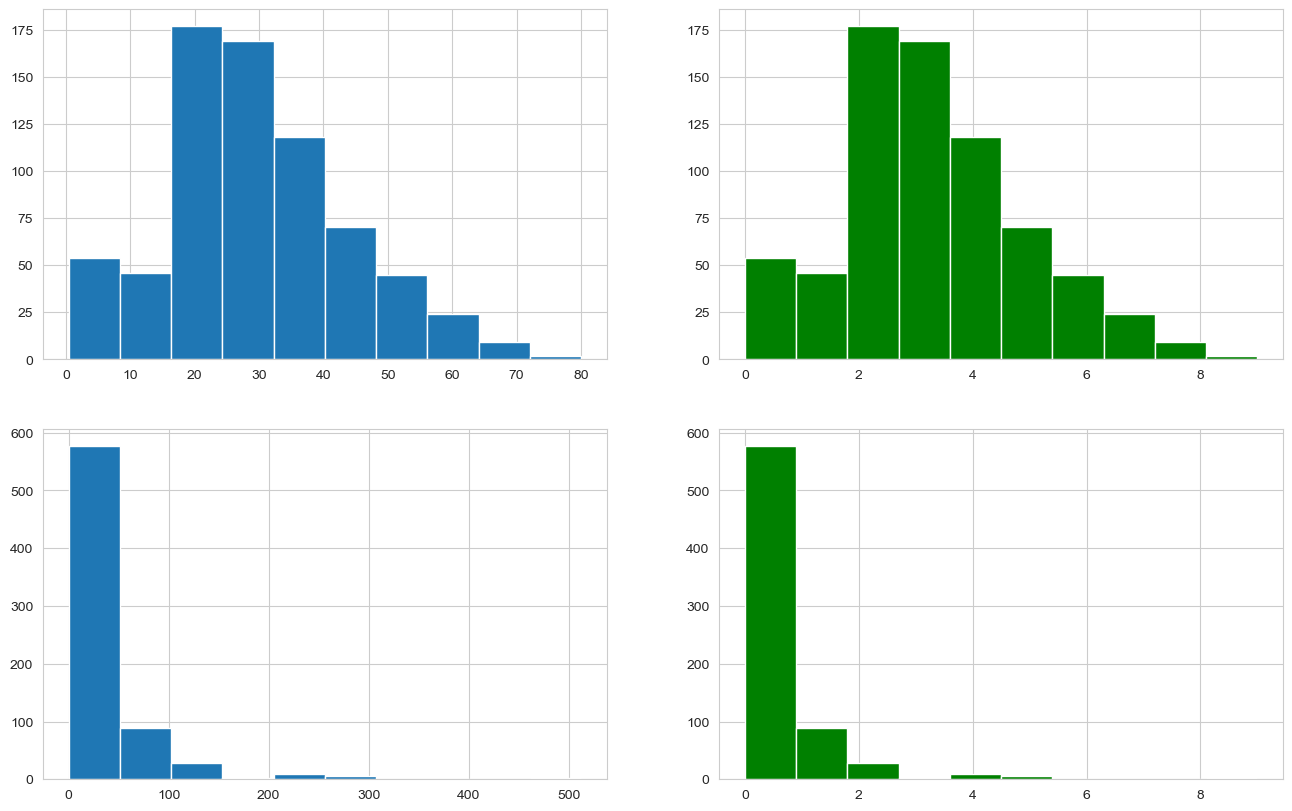

In [48]:
binarization(10,'uniform')

0.6176499556781246


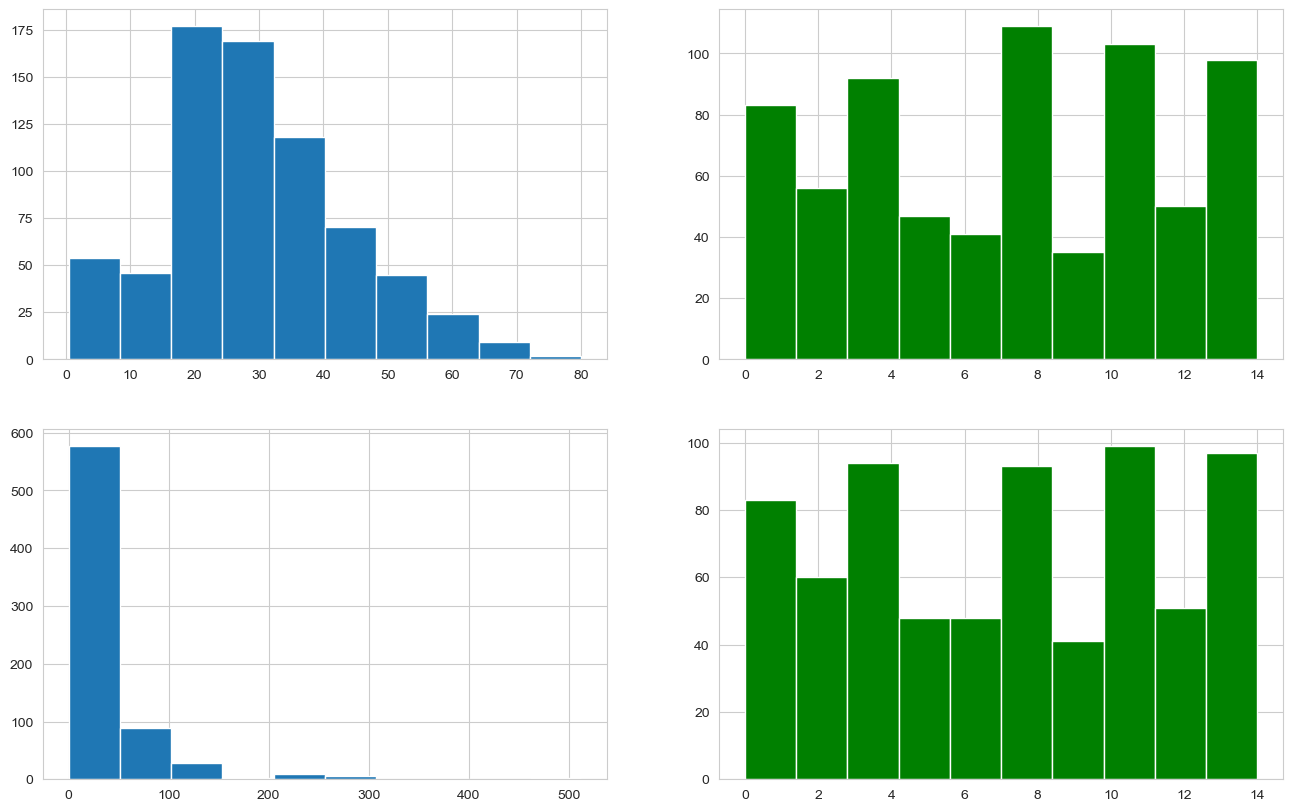

In [50]:
binarization(15,'quantile')

C:\Users\HP TECHNOLOGY\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\HP TECHNOLOGY\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


0.6148527528809219


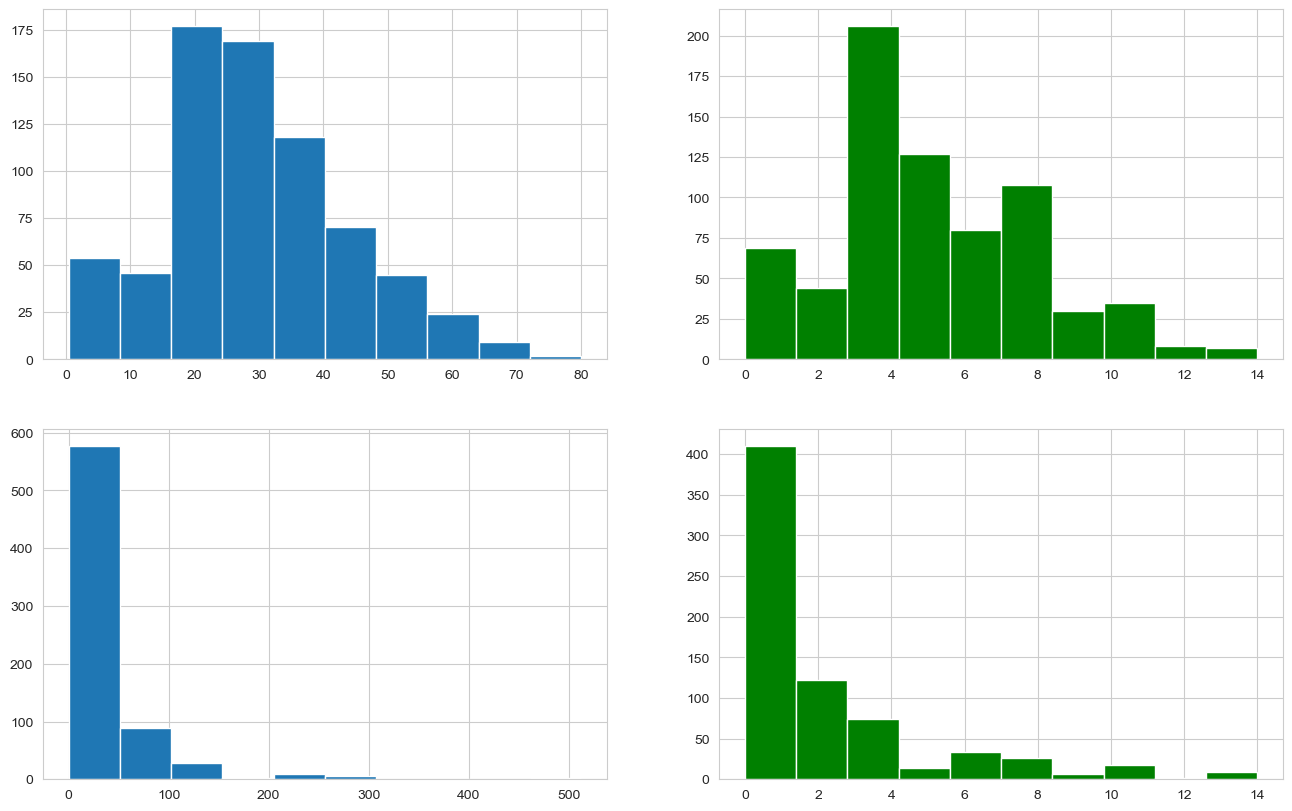

In [51]:
binarization(15,'kmeans')